In [94]:
%load_ext autoreload
%autoreload 2


In [ ]:
import baml_client as client 


In [23]:
from typing import List

from langchain_community.graphs.graph_document import Relationship
from langchain_core.documents import Document
from langchain_ollama import ChatOllama

In [35]:
model = "llama3"

llm = ChatOllama(model=model, temparature=0, temperature=0.001)

In [25]:
import pandas as pd
import tiktoken


def num_tokens_from_string(string: str, model: str = "gpt-4o") -> int:
    """Returns the number of tokens in a text string."""
    encoding = tiktoken.encoding_for_model(model)
    num_tokens = len(encoding.encode(string))
    return num_tokens


news = pd.read_csv(
    "https://raw.githubusercontent.com/tomasonjo/blog-datasets/main/news_articles.csv"
)
news["tokens"] = [
    num_tokens_from_string(f"{row['title']} {row['text']}")
    for i, row in news.iterrows()
]
news.head()

,title,date,text,tokens
0,Chevron: Best Of Breed,2031-04-06T01:36:32.000000000+00:00,JHVEPhoto Like many companies in the O&G secto...,78
1,FirstEnergy (NYSE:FE) Posts Earnings Results,2030-04-29T06:55:28.000000000+00:00,FirstEnergy (NYSE:FE – Get Rating) posted its ...,130
2,Dáil almost suspended after Sinn Féin TD put p...,2023-06-15T14:32:11.000000000+00:00,The Dáil was almost suspended on Thursday afte...,631
3,Epic’s latest tool can animate hyperrealistic ...,2023-06-15T14:00:00.000000000+00:00,"Today, Epic is releasing a new tool designed t...",528
4,"EU to Ban Huawei, ZTE from Internal Commission...",2023-06-15T13:50:00.000000000+00:00,The European Commission is planning to ban equ...,281


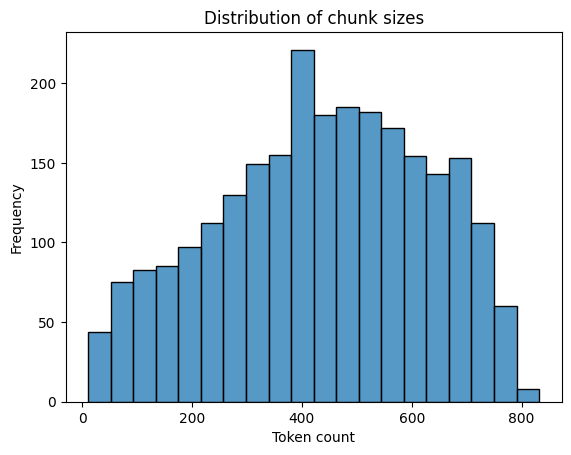

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(news["tokens"], kde=False)
plt.title("Distribution of chunk sizes")
plt.xlabel("Token count")
plt.ylabel("Frequency")
plt.show()

In [36]:
from typing import Any

from baml_client.async_client import b
from langchain_community.graphs.graph_document import GraphDocument, Node
from langchain_core.runnables import chain
from langchain_experimental.graph_transformers.llm import create_simple_model


def _format_nodes(nodes: List[Node]) -> List[Node]:
    return [
        Node(
            id=el.id.title() if isinstance(el.id, str) else el.id,
            type=el.type.capitalize() if el.type else None,
            properties=(
                el.properties.dict()
                if hasattr(el.properties, "dict")
                else el.properties
            ),
        )
        for el in nodes
    ]


def map_to_base_relationship(rel: Any) -> Relationship:
    """Map the SimpleRelationship to the base Relationship."""
    source = Node(id=rel.source_node_id, type=rel.source_node_type)
    target = Node(id=rel.target_node_id, type=rel.target_node_type)
    properties = {}
    if hasattr(rel, "properties") and rel.properties:
        properties = rel.properties.model_dump()
    return Relationship(
        source=source, target=target, type=rel.type, properties=rel.properties.dict()
    )


def _format_relationships(rels) -> List[Relationship]:
    relationships = [
        map_to_base_relationship(rel)
        for rel in rels
        if rel.type and rel.source_node_id and rel.target_node_id
    ]
    return [
        Relationship(
            source=_format_nodes([el.source])[0],
            target=_format_nodes([el.target])[0],
            type=el.type.replace(" ", "_").upper(),
            properties=(
                el.properties.dict()
                if hasattr(el.properties, "dict")
                else el.properties
            ),
        )
        for el in relationships
    ]


@chain
async def get_graph(message):
    graph = await b.ExtractGraph(graph=message.content)
    return graph


@chain
def get_entities(message):
    entities = b.ExtractDeDupe(graph=message.content)
    return entities.merged_results

In [37]:
from langchain_core.prompts import ChatPromptTemplate
from prompts.graphragprompts import system_prompt

default_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            system_prompt,
        ),
        (
            "human",
            (
                "Tip: Make sure to answer in the correct format and do "
                "not include any explanations. "
                "Use the given format to extract information from the "
                "following input: {input}"
            ),
        ),
    ]
)

In [38]:
# Define the chain

llm_type = llm._llm_type
schema = create_simple_model(llm_type=llm_type)
prompt = default_prompt
chain = prompt | llm | get_graph

In [39]:
import asyncio
from typing import List, Optional, Sequence


async def aprocess_response(document: Document) -> GraphDocument:
    resp = await chain.ainvoke({"input": document.page_content})
    return GraphDocument(
        nodes=_format_nodes(resp.nodes),
        relationships=_format_relationships(resp.relationships),
        source=document,
    )


async def aconvert_to_graph_documents(
    documents: Sequence[Document],
) -> List[GraphDocument]:

    tasks = [asyncio.create_task(aprocess_response(document)) for document in documents]
    results = await asyncio.gather(*tasks)
    return results


async def aprocess_text(texts: List[str]) -> List[GraphDocument]:
    docs = [Document(page_content=text) for text in texts]
    graph_docs = await aconvert_to_graph_documents(docs)
    return graph_docs

In [40]:
temp = await aprocess_response(Document(page_content="elon musk sued open ai"))
print(temp)

nodes=[Node(id='Elon_Musk', type='Person', properties={'description': 'entrepreneur and business magnate'}), Node(id='Open_Ai', type='Organization', properties={'description': 'artificial intelligence research laboratory'})] relationships=[Relationship(source=Node(id='Elon_Musk', type='Person', properties={}), target=Node(id='Open_Ai', type='Organization', properties={}), type='PROTEST', properties={'description': None})] source=Document(metadata={}, page_content='elon musk sued open ai')


In [42]:
from tqdm import tqdm

graph_documents = []
NUM_ARTICLES = 2000
news = news.head(NUM_ARTICLES)
titles = news["title"]
texts = news["text"]
chunk_size = 4

for i in tqdm(range(0, len(titles), chunk_size), desc="Processing Chunks"):
    title_chunk = titles[i : i + chunk_size]
    text_chunk = texts[i : i + chunk_size]
    combined_docs = []

    for title, text in zip(title_chunk, text_chunk):
        combined_docs.append(f"{title} {text}")

    try:
        docs = await aprocess_text(combined_docs)
        graph_documents.extend(docs)

    except Exception as e:
        print(f"\n\n*************Error, Request failed: {str(e)}\n\n")

    print(f"--- End of Chunk {i} ---")

Processing Chunks:   0%|          | 1/500 [01:19<11:01:53, 79.59s/it]

--- End of Chunk 0 ---


Processing Chunks:   0%|          | 2/500 [02:28<10:07:39, 73.21s/it]

--- End of Chunk 4 ---


Processing Chunks:   1%|          | 3/500 [03:47<10:29:34, 76.00s/it]

--- End of Chunk 8 ---


Processing Chunks:   1%|          | 4/500 [05:14<11:04:28, 80.38s/it]

--- End of Chunk 12 ---


Processing Chunks:   1%|          | 5/500 [06:28<10:43:01, 77.94s/it]

--- End of Chunk 16 ---


Processing Chunks:   1%|          | 6/500 [07:35<10:11:56, 74.32s/it]

--- End of Chunk 20 ---


Processing Chunks:   1%|▏         | 7/500 [08:57<10:30:50, 76.78s/it]

--- End of Chunk 24 ---


Processing Chunks:   2%|▏         | 8/500 [10:13<10:28:44, 76.68s/it]

--- End of Chunk 28 ---


Processing Chunks:   2%|▏         | 9/500 [13:33<15:41:30, 115.05s/it]

--- End of Chunk 32 ---


Processing Chunks:   2%|▏         | 10/500 [15:02<14:33:58, 107.02s/it]

--- End of Chunk 36 ---


Processing Chunks:   2%|▏         | 11/500 [16:02<12:34:47, 92.61s/it] 

--- End of Chunk 40 ---


Processing Chunks:   2%|▏         | 12/500 [19:48<18:04:17, 133.31s/it]

--- End of Chunk 44 ---


Processing Chunks:   3%|▎         | 13/500 [20:59<15:28:11, 114.36s/it]

--- End of Chunk 48 ---


Processing Chunks:   3%|▎         | 14/500 [22:04<13:24:49, 99.36s/it] 

--- End of Chunk 52 ---


Processing Chunks:   3%|▎         | 15/500 [24:01<14:07:48, 104.88s/it]

--- End of Chunk 56 ---


Processing Chunks:   3%|▎         | 16/500 [26:23<15:35:18, 115.95s/it]

--- End of Chunk 60 ---


Processing Chunks:   3%|▎         | 17/500 [27:35<13:46:35, 102.68s/it]

--- End of Chunk 64 ---


Processing Chunks:   4%|▎         | 18/500 [29:12<13:31:53, 101.07s/it]

--- End of Chunk 68 ---


Processing Chunks:   4%|▍         | 19/500 [30:35<12:47:07, 95.69s/it] 

--- End of Chunk 72 ---


Processing Chunks:   4%|▍         | 20/500 [31:45<11:41:52, 87.73s/it]

--- End of Chunk 76 ---


Processing Chunks:   4%|▍         | 21/500 [33:33<12:29:34, 93.89s/it]

--- End of Chunk 80 ---


Processing Chunks:   4%|▍         | 22/500 [34:57<12:04:57, 91.00s/it]

--- End of Chunk 84 ---


Processing Chunks:   5%|▍         | 23/500 [36:19<11:42:06, 88.32s/it]

--- End of Chunk 88 ---


Processing Chunks:   5%|▍         | 24/500 [37:33<11:07:30, 84.14s/it]

--- End of Chunk 92 ---


Processing Chunks:   5%|▌         | 25/500 [39:20<12:00:00, 90.95s/it]

--- End of Chunk 96 ---


Processing Chunks:   5%|▌         | 26/500 [40:24<10:53:51, 82.77s/it]

--- End of Chunk 100 ---


Processing Chunks:   5%|▌         | 27/500 [41:52<11:05:42, 84.44s/it]

--- End of Chunk 104 ---


Processing Chunks:   6%|▌         | 28/500 [43:44<12:09:17, 92.71s/it]

--- End of Chunk 108 ---


Processing Chunks:   6%|▌         | 29/500 [44:54<11:13:18, 85.77s/it]

--- End of Chunk 112 ---


Processing Chunks:   6%|▌         | 30/500 [1:10:45<68:35:01, 525.32s/it]

--- End of Chunk 116 ---


Processing Chunks:   6%|▌         | 31/500 [1:12:11<51:16:44, 393.61s/it]

--- End of Chunk 120 ---


Processing Chunks:   6%|▋         | 32/500 [1:13:43<39:23:57, 303.07s/it]

--- End of Chunk 124 ---


Processing Chunks:   7%|▋         | 33/500 [1:17:19<35:55:30, 276.94s/it]

--- End of Chunk 128 ---


Processing Chunks:   7%|▋         | 34/500 [1:18:30<27:52:19, 215.32s/it]

--- End of Chunk 132 ---


Processing Chunks:   7%|▋         | 35/500 [1:19:48<22:27:19, 173.85s/it]

--- End of Chunk 136 ---


Processing Chunks:   7%|▋         | 36/500 [1:20:59<18:26:44, 143.11s/it]

--- End of Chunk 140 ---


Processing Chunks:   7%|▋         | 37/500 [1:22:16<15:50:21, 123.16s/it]

--- End of Chunk 144 ---


Processing Chunks:   8%|▊         | 38/500 [1:36:48<44:38:31, 347.86s/it]

--- End of Chunk 148 ---


Processing Chunks:   8%|▊         | 39/500 [2:01:06<87:12:07, 680.97s/it]

--- End of Chunk 152 ---


Processing Chunks:   8%|▊         | 40/500 [2:19:21<102:53:19, 805.22s/it]

--- End of Chunk 156 ---


Processing Chunks:   8%|▊         | 41/500 [2:36:38<111:30:41, 874.60s/it]

--- End of Chunk 160 ---


Processing Chunks:   8%|▊         | 42/500 [2:53:31<116:33:37, 916.20s/it]

--- End of Chunk 164 ---


Processing Chunks:   9%|▊         | 43/500 [2:54:34<83:48:43, 660.23s/it] 

--- End of Chunk 168 ---


Processing Chunks:   9%|▉         | 44/500 [3:11:36<97:23:59, 768.95s/it]

--- End of Chunk 172 ---


Processing Chunks:   9%|▉         | 45/500 [7:23:24<640:52:32, 5070.66s/it]

--- End of Chunk 176 ---


Processing Chunks:   9%|▉         | 46/500 [7:41:22<488:23:16, 3872.68s/it]

--- End of Chunk 180 ---


Processing Chunks:   9%|▉         | 47/500 [7:57:50<378:26:13, 3007.45s/it]

--- End of Chunk 184 ---


Processing Chunks:  10%|▉         | 48/500 [8:16:43<306:58:38, 2444.95s/it]

--- End of Chunk 188 ---


Processing Chunks:  10%|▉         | 49/500 [8:32:59<251:05:12, 2004.24s/it]

--- End of Chunk 192 ---


Processing Chunks:  10%|█         | 50/500 [8:49:45<213:07:10, 1704.96s/it]

--- End of Chunk 196 ---


Processing Chunks:  10%|█         | 51/500 [9:14:02<203:21:55, 1630.55s/it]

--- End of Chunk 200 ---


Processing Chunks:  10%|█         | 52/500 [9:20:30<156:30:14, 1257.62s/it]

--- End of Chunk 204 ---


Processing Chunks:  11%|█         | 53/500 [9:38:05<148:36:06, 1196.79s/it]

--- End of Chunk 208 ---


Processing Chunks:  11%|█         | 54/500 [9:54:41<140:48:10, 1136.53s/it]

--- End of Chunk 212 ---


Processing Chunks:  11%|█         | 55/500 [10:12:48<138:40:53, 1121.92s/it]

--- End of Chunk 216 ---


Processing Chunks:  11%|█         | 56/500 [10:13:58<99:26:11, 806.24s/it]  

--- End of Chunk 220 ---


Processing Chunks:  11%|█▏        | 57/500 [10:48:38<146:13:00, 1188.22s/it]

--- End of Chunk 224 ---


Processing Chunks:  12%|█▏        | 58/500 [10:52:15<110:07:03, 896.89s/it] 

--- End of Chunk 228 ---


Processing Chunks:  12%|█▏        | 59/500 [10:57:46<89:04:59, 727.21s/it] 

--- End of Chunk 232 ---


Processing Chunks:  12%|█▏        | 60/500 [11:03:51<75:35:47, 618.52s/it]

--- End of Chunk 236 ---


Processing Chunks:  12%|█▏        | 61/500 [11:05:13<55:47:18, 457.49s/it]

--- End of Chunk 240 ---


Processing Chunks:  12%|█▏        | 62/500 [11:06:45<42:21:08, 348.10s/it]

--- End of Chunk 244 ---


Processing Chunks:  13%|█▎        | 63/500 [11:07:51<31:58:22, 263.39s/it]

--- End of Chunk 248 ---


Processing Chunks:  13%|█▎        | 64/500 [11:09:18<25:28:22, 210.33s/it]

--- End of Chunk 252 ---


Processing Chunks:  13%|█▎        | 65/500 [11:10:35<20:35:41, 170.44s/it]

--- End of Chunk 256 ---


Processing Chunks:  13%|█▎        | 66/500 [11:11:32<16:25:49, 136.29s/it]

--- End of Chunk 260 ---


Processing Chunks:  13%|█▎        | 67/500 [11:12:41<13:58:16, 116.16s/it]

--- End of Chunk 264 ---


Processing Chunks:  14%|█▎        | 68/500 [11:14:09<12:56:24, 107.83s/it]

--- End of Chunk 268 ---


Processing Chunks:  14%|█▍        | 69/500 [11:31:29<46:22:32, 387.36s/it]

--- End of Chunk 272 ---


Processing Chunks:  14%|█▍        | 70/500 [11:48:21<68:40:09, 574.91s/it]

--- End of Chunk 276 ---


Processing Chunks:  14%|█▍        | 71/500 [12:05:24<84:30:45, 709.20s/it]

--- End of Chunk 280 ---


Processing Chunks:  14%|█▍        | 72/500 [12:23:59<98:47:06, 830.90s/it]

--- End of Chunk 284 ---


Processing Chunks:  15%|█▍        | 73/500 [12:25:54<73:05:40, 616.25s/it]

--- End of Chunk 288 ---


Processing Chunks:  15%|█▍        | 74/500 [12:27:01<53:25:24, 451.47s/it]

--- End of Chunk 292 ---


Processing Chunks:  15%|█▌        | 75/500 [12:28:17<40:00:06, 338.84s/it]

--- End of Chunk 296 ---


Processing Chunks:  15%|█▌        | 76/500 [12:29:48<31:07:34, 264.28s/it]

--- End of Chunk 300 ---


Processing Chunks:  15%|█▌        | 77/500 [12:32:22<27:10:04, 231.22s/it]

--- End of Chunk 304 ---


Processing Chunks:  16%|█▌        | 78/500 [12:33:37<21:37:23, 184.46s/it]

--- End of Chunk 308 ---


Processing Chunks:  16%|█▌        | 79/500 [12:55:22<60:54:09, 520.78s/it]

--- End of Chunk 312 ---


Processing Chunks:  16%|█▌        | 80/500 [12:56:55<45:46:49, 392.40s/it]

--- End of Chunk 316 ---


Processing Chunks:  16%|█▌        | 81/500 [13:31:40<104:45:34, 900.08s/it]

--- End of Chunk 320 ---


Processing Chunks:  16%|█▋        | 82/500 [13:48:29<108:18:30, 932.80s/it]

--- End of Chunk 324 ---


Processing Chunks:  17%|█▋        | 83/500 [14:04:38<109:17:23, 943.51s/it]

--- End of Chunk 328 ---


Processing Chunks:  17%|█▋        | 84/500 [14:16:43<101:28:42, 878.18s/it]

--- End of Chunk 332 ---


Processing Chunks:  17%|█▋        | 85/500 [14:28:21<94:59:57, 824.09s/it] 

--- End of Chunk 336 ---


Processing Chunks:  17%|█▋        | 86/500 [14:30:13<70:11:47, 610.41s/it]

--- End of Chunk 340 ---


Processing Chunks:  17%|█▋        | 86/500 [14:30:26<69:50:16, 607.29s/it]


CancelledError: 

In [44]:
len(graph_documents)

344

#### Detemine the number of failed tool calls using the llm and baml

In [115]:
empty_count = 0

for doc in graph_documents:
    if not doc.nodes:
        empty_count += 1
print(f"Percentage missing: {empty_count/len(graph_documents)*100}")

Percentage missing: 0.5813953488372093


In [ ]:
import pickle

# Save the array to a file
with open("data/graph_documents.pkl", "wb") as f:
    pickle.dump(graph_documents, f)

In [45]:
import os

from langchain_community.graphs import Neo4jGraph

os.environ["NEO4J_URI"] = "bolt://localhost:7687"
os.environ["NEO4J_USERNAME"] = "neo4j"
os.environ["NEO4J_PASSWORD"] = "rag123456"
os.environ["DATABASE"] = "graphragdemo"


graph = Neo4jGraph(
    url="bolt://localhost:7687",
    username="neo4j",
    password="rag123456",
    database="graphragdemo",
)

In [46]:
graph.add_graph_documents(graph_documents, baseEntityLabel=True, include_source=True)

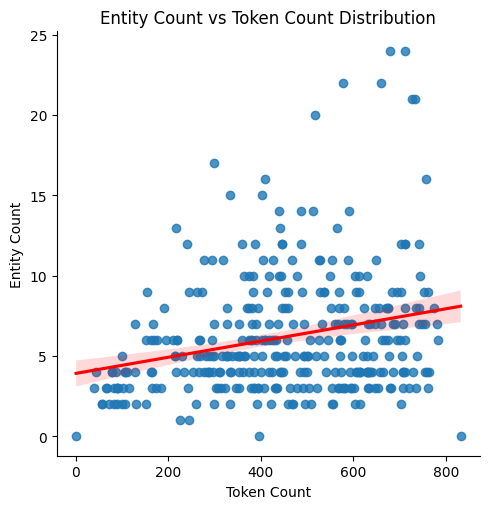

In [47]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tiktoken


def num_tokens_from_string(string: str, model: str = "gpt-4o") -> int:
    """Returns the number of tokens in a text string."""
    encoding = tiktoken.encoding_for_model(model)
    num_tokens = len(encoding.encode(string))
    return num_tokens


entity_dist = graph.query(
    """
MATCH (d:Document)
RETURN d.text AS text,
       count {(d)-[:MENTIONS]->()} AS entity_count
"""
)
entity_dist_df = pd.DataFrame.from_records(entity_dist)
entity_dist_df["token_count"] = [
    num_tokens_from_string(str(el)) for el in entity_dist_df["text"]
]
# Scatter plot with regression line
sns.lmplot(
    x="token_count", y="entity_count", data=entity_dist_df, line_kws={"color": "red"}
)
plt.title("Entity Count vs Token Count Distribution")
plt.xlabel("Token Count")
plt.ylabel("Entity Count")
plt.show()

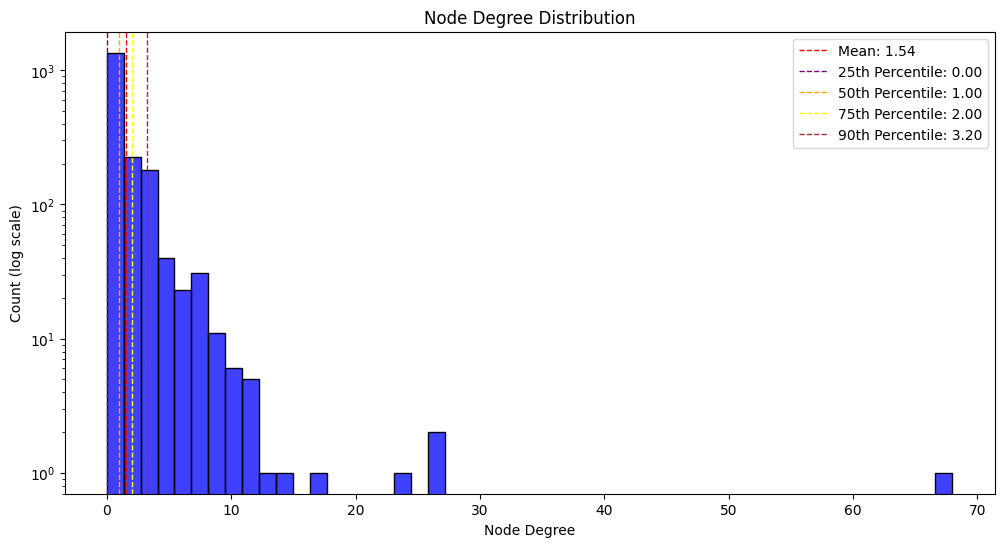

In [48]:
import numpy as np

degree_dist = graph.query(
    """
MATCH (e:__Entity__)
RETURN count {(e)-[:!MENTIONS]-()} AS node_degree
"""
)
degree_dist_df = pd.DataFrame.from_records(degree_dist)

# Calculate mean and median
mean_degree = np.mean(degree_dist_df["node_degree"])
percentiles = np.percentile(degree_dist_df["node_degree"], [25, 50, 75, 90])
# Create a histogram with a logarithmic scale
plt.figure(figsize=(12, 6))
sns.histplot(degree_dist_df["node_degree"], bins=50, kde=False, color="blue")
# Use a logarithmic scale for the x-axis
plt.yscale("log")
# Adding labels and title
plt.xlabel("Node Degree")
plt.ylabel("Count (log scale)")
plt.title("Node Degree Distribution")
# Add mean, median, and percentile lines
plt.axvline(
    mean_degree,
    color="red",
    linestyle="dashed",
    linewidth=1,
    label=f"Mean: {mean_degree:.2f}",
)
plt.axvline(
    percentiles[0],
    color="purple",
    linestyle="dashed",
    linewidth=1,
    label=f"25th Percentile: {percentiles[0]:.2f}",
)
plt.axvline(
    percentiles[1],
    color="orange",
    linestyle="dashed",
    linewidth=1,
    label=f"50th Percentile: {percentiles[1]:.2f}",
)
plt.axvline(
    percentiles[2],
    color="yellow",
    linestyle="dashed",
    linewidth=1,
    label=f"75th Percentile: {percentiles[2]:.2f}",
)
plt.axvline(
    percentiles[3],
    color="brown",
    linestyle="dashed",
    linewidth=1,
    label=f"90th Percentile: {percentiles[3]:.2f}",
)
# Add legend
plt.legend()
# Show the plot
plt.show()

In [49]:
graph.query(
    """
MATCH (n:`__Entity__`)
RETURN "node" AS type,
       count(*) AS total_count,
       count(n.description) AS non_null_descriptions
UNION ALL
MATCH (n)-[r:!MENTIONS]->()
RETURN "relationship" AS type,
       count(*) AS total_count,
       count(r.description) AS non_null_descriptions
"""
)

[{'type': 'node', 'total_count': 1879, 'non_null_descriptions': 962},
 {'type': 'relationship', 'total_count': 1450, 'non_null_descriptions': 358}]

In [75]:
from langchain_community.vectorstores import Neo4jVector
from langchain_ollama import OllamaEmbeddings

# Specify your Neo4j connection details and database
from graphdatascience import GraphDataScience
import os

# Initialize GDS with the specific database
gds = GraphDataScience(
    os.environ["NEO4J_URI"],
    auth=(os.environ["NEO4J_USERNAME"], os.environ["NEO4J_PASSWORD"]),
)
gds.set_database(os.environ["DATABASE"])  # Set the database here

# Create embeddings
embeddings = OllamaEmbeddings(
    model="llama3",
)

# Initialize the Neo4jVector instance and update the nodes with embeddings
vector = Neo4jVector.from_existing_graph(
    embeddings,
    node_label="__Entity__",
    text_node_properties=["id", "description"],
    embedding_node_property="embedding",
    database=os.environ["DATABASE"],
)

print("Embedding update complete.")


Embedding update complete.


In [79]:
G, result = gds.graph.project(
    "entities",                   #  Graph name
    "__Entity__",                 #  Node projection
    "*",                          #  Relationship projection
    nodeProperties=["embedding"]  #  Configuration parameters
)

In [80]:
similarity_threshold = 0.95

gds.knn.mutate(
    G,
    nodeProperties=["embedding"],
    mutateRelationshipType="SIMILAR",
    mutateProperty="score",
    similarityCutoff=similarity_threshold,
)

K-Nearest Neighbours: 100%|██████████| 100.0/100 [00:01<00:00, 110.46%/s]

ranIterations                                                            10
nodePairsConsidered                                                  886993
didConverge                                                            True
preProcessingMillis                                                       2
computeMillis                                                          1498
mutateMillis                                                             28
postProcessingMillis                                                      0
nodesCompared                                                          1879
relationshipsWritten                                                   1934
similarityDistribution    {'min': 0.9500160217285156, 'p5': 0.9507484436...
configuration             {'mutateProperty': 'score', 'jobId': '198c5612...
Name: 0, dtype: object

K-Nearest Neighbours: 100%|██████████| 100.0/100 [00:02<00:00, 110.46%/s]

In [81]:
gds.wcc.write(G, writeProperty="wcc", relationshipTypes=["SIMILAR"])

K-Nearest Neighbours: 100%|██████████| 100.0/100 [00:06<00:00, 16.66%/s] 


writeMillis                                                             20
nodePropertiesWritten                                                 1879
componentCount                                                        1419
componentDistribution    {'min': 1, 'p5': 1, 'max': 103, 'p999': 31, 'p...
postProcessingMillis                                                     5
preProcessingMillis                                                      0
computeMillis                                                            5
configuration            {'writeProperty': 'wcc', 'jobId': '4a4318a6-29...
Name: 0, dtype: object

In [82]:
word_edit_distance = 3
potential_duplicate_candidates = graph.query(
    """MATCH (e:`__Entity__`)
    WHERE size(e.id) > 4 // longer than 4 characters
    WITH e.wcc AS community, collect(e) AS nodes, count(*) AS count
    WHERE count > 1
    UNWIND nodes AS node
    // Add text distance
    WITH distinct
      [n IN nodes WHERE apoc.text.distance(toLower(node.id), toLower(n.id)) < $distance | n.id] AS intermediate_results
    WHERE size(intermediate_results) > 1
    WITH collect(intermediate_results) AS results
    // combine groups together if they share elements
    UNWIND range(0, size(results)-1, 1) as index
    WITH results, index, results[index] as result
    WITH apoc.coll.sort(reduce(acc = result, index2 IN range(0, size(results)-1, 1) |
            CASE WHEN index <> index2 AND
                size(apoc.coll.intersection(acc, results[index2])) > 0
                THEN apoc.coll.union(acc, results[index2])
                ELSE acc
            END
    )) as combinedResult
    WITH distinct(combinedResult) as combinedResult
    // extra filtering
    WITH collect(combinedResult) as allCombinedResults
    UNWIND range(0, size(allCombinedResults)-1, 1) as combinedResultIndex
    WITH allCombinedResults[combinedResultIndex] as combinedResult, combinedResultIndex, allCombinedResults
    WHERE NOT any(x IN range(0,size(allCombinedResults)-1,1)
        WHERE x <> combinedResultIndex
        AND apoc.coll.containsAll(allCombinedResults[x], combinedResult)
    )
    RETURN combinedResult
    """,
    params={"distance": word_edit_distance},
)


In [83]:
potential_duplicate_candidates[:5]

[{'combinedResult': ['David Van', 'Davidvan']},
 {'combinedResult': ['Cyb003', 'Cyb004']},
 {'combinedResult': ['Delta Air Lines', 'Delta_Air_Lines']},
 {'combinedResult': ['Elon Musk', 'Elonmusk']},
 {'combinedResult': ['Market', 'Markets']}]

In [89]:
# from baml_client import reset_baml_env_vars
# import os

# reset_baml_env_vars(dict(os.environ))

In [90]:
from prompts.graphragprompts import system_prompt_duplicates, user_template

extraction_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            system_prompt_duplicates,
        ),
        (
            "human",
            user_template,
        ),
    ]
)

In [100]:
from langchain_community.graphs.graph_document import GraphDocument, Node, Relationship
from langchain_core.runnables import chain


@chain
def get_entities(message):
    entities = client.b.ExtractDeDupe(graph=message.content)
    return entities.merged_results

In [101]:
extraction_chain = extraction_prompt | llm | get_entities

In [102]:
entities = ["Star Ocean The Second Story R", "Star Ocean: The Second Story R"]
print(extraction_chain.invoke(entities))

['Star Ocean: The Second Story R']


In [103]:
def entity_resolution(entities: List[str]) -> Optional[List[str]]:
    return [extraction_chain.invoke(entities)]


entity_resolution(potential_duplicate_candidates[0]["combinedResult"])

[['David Van']]

In [104]:
from concurrent.futures import ThreadPoolExecutor, as_completed
from typing import List, Optional

from tqdm import tqdm

MAX_WORKERS = 3

import time
from typing import List, Optional


def entity_resolution(
    entities: List[str], retries: int = 3, delay: float = 30.0
) -> Optional[List[str]]:
    for attempt in range(1, retries + 1):
        try:
            return [extraction_chain.invoke(entities)]
        except Exception as e:
            print(f"Attempt {attempt} failed for entities: {entities}, Error: {e}")
            if attempt < retries:
                print(f"Retrying in {delay} seconds...")
                time.sleep(delay)
            else:
                print("Max retries reached. Returning None.")
                return None


merged_entities = []
# Example threading code with exception handling
with ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
    # Submitting all tasks and creating a list of future objects
    futures = [
        executor.submit(entity_resolution, el["combinedResult"])
        for el in potential_duplicate_candidates
    ]

    for future in tqdm(
        as_completed(futures), total=len(futures), desc="Processing documents"
    ):
        try:
            to_merge = (
                future.result()
            )  # This will raise if entity_resolution had an exception
            if to_merge:
                merged_entities.extend(to_merge)
        except Exception as e:
            print(f"Error in future result: {e}")
            # You can log the error or continue without any action if needed
            continue

Processing documents: 100%|██████████| 26/26 [00:23<00:00,  1.12it/s]


In [105]:
graph.query(
    """
UNWIND $data AS candidates
CALL {
  WITH candidates
  MATCH (e:__Entity__) WHERE e.id IN candidates
  RETURN collect(e) AS nodes
}
CALL apoc.refactor.mergeNodes(nodes, {properties: {
    `.*`: 'discard'
}})
YIELD node
RETURN count(*)
""",
    params={"data": merged_entities},
)

[{'count(*)': 18}]

In [106]:
G, result = gds.graph.project(
    "communities",  #  Graph name
    "__Entity__",  #  Node projection
    {
        "_ALL_": {
            "type": "*",
            "orientation": "UNDIRECTED",
            "properties": {"weight": {"property": "*", "aggregation": "COUNT"}},
        }
    },
)

In [107]:
wcc = gds.wcc.stats(G)
print(f"Component count: {wcc['componentCount']}")
print(f"Component distribution: {wcc['componentDistribution']}")

Component count: 722
Component distribution: {'min': 1, 'p5': 1, 'max': 305, 'p999': 305, 'p99': 14, 'p1': 1, 'p10': 1, 'p90': 4, 'p50': 1, 'p25': 1, 'p75': 2, 'p95': 6, 'mean': 2.596952908587258}


In [108]:
gds.leiden.write(
    G,
    writeProperty="communities",
    includeIntermediateCommunities=True,
    relationshipWeightProperty="weight",
)

writeMillis                                                             19
nodePropertiesWritten                                                 1875
ranLevels                                                                4
didConverge                                                           True
nodeCount                                                             1875
communityCount                                                         732
communityDistribution    {'min': 1, 'p5': 1, 'max': 77, 'p999': 77, 'p9...
modularity                                                        0.970618
modularities             [0.8718561236623066, 0.9618311533888227, 0.970...
postProcessingMillis                                                     1
preProcessingMillis                                                      0
computeMillis                                                           62
configuration            {'writeProperty': 'communities', 'theta': 0.01...
Name: 0, dtype: object

In [109]:
graph.query(
    "CREATE CONSTRAINT IF NOT EXISTS FOR (c:__Community__) REQUIRE c.id IS UNIQUE;"
)

[]

In [110]:
graph.query(
    """
MATCH (e:`__Entity__`)
UNWIND range(0, size(e.communities) - 1 , 1) AS index
CALL {
  WITH e, index
  WITH e, index
  WHERE index = 0
  MERGE (c:`__Community__` {id: toString(index) + '-' + toString(e.communities[index])})
  ON CREATE SET c.level = index
  MERGE (e)-[:IN_COMMUNITY]->(c)
  RETURN count(*) AS count_0
}
CALL {
  WITH e, index
  WITH e, index
  WHERE index > 0
  MERGE (current:`__Community__` {id: toString(index) + '-' + toString(e.communities[index])})
  ON CREATE SET current.level = index
  MERGE (previous:`__Community__` {id: toString(index - 1) + '-' + toString(e.communities[index - 1])})
  ON CREATE SET previous.level = index - 1
  MERGE (previous)-[:IN_COMMUNITY]->(current)
  RETURN count(*) AS count_1
}
RETURN count(*)
"""
)

[{'count(*)': 7500}]

In [111]:
graph.query(
    """
MATCH (c:__Community__)<-[:IN_COMMUNITY*]-(:__Entity__)<-[:MENTIONS]-(d:Document)
WITH c, count(distinct d) AS rank
SET c.community_rank = rank;
"""
)

[]

In [112]:
community_size = graph.query(
    """
MATCH (c:__Community__)<-[:IN_COMMUNITY*]-(e:__Entity__)
WITH c, count(distinct e) AS entities
RETURN split(c.id, '-')[0] AS level, entities
"""
)
community_size_df = pd.DataFrame.from_records(community_size)
percentiles_data = []
for level in community_size_df["level"].unique():
    subset = community_size_df[community_size_df["level"] == level]["entities"]
    num_communities = len(subset)
    percentiles = np.percentile(subset, [25, 50, 75, 90, 99])
    percentiles_data.append(
        [
            level,
            num_communities,
            percentiles[0],
            percentiles[1],
            percentiles[2],
            percentiles[3],
            percentiles[4],
            max(subset),
        ]
    )

# Create a DataFrame with the percentiles
percentiles_df = pd.DataFrame(
    percentiles_data,
    columns=[
        "Level",
        "Number of communities",
        "25th Percentile",
        "50th Percentile",
        "75th Percentile",
        "90th Percentile",
        "99th Percentile",
        "Max",
    ],
)
percentiles_df

,Level,Number of communities,25th Percentile,50th Percentile,75th Percentile,90th Percentile,99th Percentile,Max
0,0,858,1.0,1.0,2.0,4.0,10.43,37
1,1,749,1.0,1.0,2.0,5.0,18.52,77
2,2,734,1.0,1.0,2.0,5.0,27.67,77
3,3,732,1.0,1.0,2.0,5.0,27.69,77


In [113]:
community_info = graph.query(
    """
MATCH (c:`__Community__`)<-[:IN_COMMUNITY*]-(e:__Entity__)
WHERE c.level IN [0,1]
WITH c, collect(e) AS nodes
WHERE size(nodes) > 1
CALL apoc.path.subgraphAll(nodes[0], {
	whitelistNodes:nodes
})
YIELD relationships
RETURN c.id AS communityId,
       [n in nodes | {id: n.id, description: n.description, type: [el in labels(n) WHERE el <> '__Entity__'][0]}] AS nodes,
       [r in relationships | {start: startNode(r).id, type: type(r), end: endNode(r).id, description: r.description}] AS rels
"""
)

In [114]:
community_info

[{'communityId': '0-1',
  'nodes': [{'id': 'Chevron',
    'description': 'Energy company',
    'type': 'Company'},
   {'id': 'O&G Sector', 'description': None, 'type': 'Industry'},
   {'id': 'Q2', 'description': None, 'type': 'Period of time'}],
  'rels': [{'start': 'Chevron',
    'description': None,
    'type': 'IS_A_PART_OF',
    'end': 'O&G Sector'},
   {'start': 'Q2',
    'description': 'risen sharply (~25%) during that same time frame',
    'type': 'EARNINGS_ESTIMATES',
    'end': 'Chevron'}]},
 {'communityId': '0-396',
  'nodes': [{'id': 'Nyse',
    'description': 'Stock exchange',
    'type': 'Stock exchange'},
   {'id': 'Delta_Air_Lines',
    'description': 'Airline company',
    'type': 'Airline company'},
   {'id': 'Board_Of_Directors',
    'description': 'Group of individuals responsible for making decisions',
    'type': 'Group of individuals'}],
  'rels': [{'start': 'Delta_Air_Lines',
    'description': None,
    'type': 'HAS_BOARD',
    'end': 'Board_Of_Directors'},
   {